In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


### Preprocessing of the images

In [2]:
%matplotlib inline

def normalize_image(img):
    means = np.mean(img, axis=(0, 1))
    means = means[None,:]
    
    std = np.std(img, axis=(0, 1))
    std = std[None,:]
    return (img - means) / std

def preprocess_image(img):
    img_crop = img[56:150, :, :]
    img_resize = cv2.resize(img_crop, (200, 66))
    img_normed = normalize_image(img_resize)
    return img_normed

### Helper Class to load data and generate batches

In [3]:
class DataHelper:
    def __init__(self, data_file):
        xs = []
        ys = []
        
        with open(data_file) as f:
            header = f.readline()
            dirname = os.path.dirname(data_file)
            for line in f:
                fields = line.split(", ")
                # Loading only the center images
                xs.append(os.path.join(dirname, fields[0]))
                ys.append(np.float32(fields[3]))
                
        c = list(zip(xs, ys))
        random.shuffle(c)
        xs, ys = zip(*c)
        
        self._batch_pointer = 0
        self._train_xs = xs[:(int)(len(xs) * 0.9)]
        self._train_ys = ys[:(int)(len(xs) * 0.9)]

        val_xs = []
        val_ys = []
        val_size = (int)(len(xs) * 0.1)
        for i in range(val_size):
            img = plt.imread(xs[-i])
            img_pre = preprocess_image(img)
            
            val_xs.append(img_pre)
            val_ys.append(ys[-i])
        
        self._val_xs = np.asarray(val_xs)
        self._val_ys = np.asarray(val_ys)
        
    def data_size(self):
        return len(self._train_ys) + len(self._val_ys)
    
    def val_data(self):
        return self._val_xs, self._val_ys

    def next_train_batch(self, batch_size):
        x_out = []
        y_out = []
        for i in range(batch_size):
            data_idx = (self._batch_pointer + i) % len(self._train_ys)
            
            img = plt.imread(self._train_xs[data_idx])
            img_pre = preprocess_image(img)
            
            x_out.append(img_pre)            
            y_out.append(self._train_ys[data_idx])

        self._batch_pointer += batch_size
        return np.asarray(x_out), np.asarray(y_out)

In [4]:
dh = DataHelper('data/driving_log.csv')
print(dh.data_size())

8035


In [5]:
x, y = dh.next_train_batch(64)
print(x.shape, y.shape)

(64, 66, 200, 3) (64,)


(66, 200, 3)


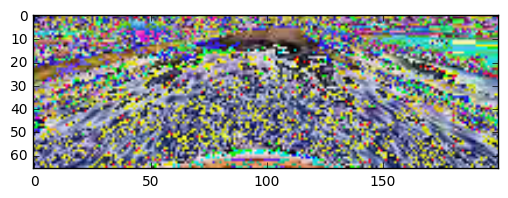

In [6]:
idx = random.randint(0, len(y) - 1)
img = x[idx]
print(img.shape)
plt.imshow(img, cmap='gray')

In [7]:
def simple_conv():
    model = Sequential()
    
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3),
                            activation='relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
    
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))

    model.add(Flatten())
    model.add(Dropout(0.75))
    model.add(Dense(1164, activation='relu'))    
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='tanh'))

    opt = Adam(lr=0.0001)
    model.compile(optimizer=opt, loss='mean_squared_error')

    return model

In [8]:
model = simple_conv()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 3, 20, 64)     27712       convolution2d_3[0][0]            
___________________________________________________________________________________________

In [9]:
EPOCHS = 10
BATCH_SIZE = 64
EVALUATE_AT = 50
DATA_SIZE = dh.data_size()

val_x, val_y = dh.val_data()

step_start = time.time()
num_steps = EPOCHS * DATA_SIZE // BATCH_SIZE
print("Training for %d steps" % num_steps)

for steps in range(num_steps):
    x, y = dh.next_train_batch(BATCH_SIZE)
    train_loss = model.train_on_batch(x, y)
    
    if steps % EVALUATE_AT == 0:
        val_loss = model.evaluate(val_x, val_y, verbose=0)
    
        time_taken = time.time() - step_start
        print("Epoch {} Steps {} train loss {:0.6f} validation loss {:0.6f} time taken {:0.1f}s".format(
                steps // DATA_SIZE, steps, train_loss, val_loss, time_taken))
    
        step_start = time.time()
        model.save("model.h5")

Training for 1255 steps
Epoch 0 Steps 0 train loss 0.071030 validation loss 0.017669 time taken 11.7s
Epoch 0 Steps 50 train loss 0.011721 validation loss 0.017066 time taken 20.7s
Epoch 0 Steps 100 train loss 0.022656 validation loss 0.017037 time taken 20.3s
Epoch 0 Steps 150 train loss 0.014891 validation loss 0.017019 time taken 20.0s
Epoch 0 Steps 200 train loss 0.024681 validation loss 0.017005 time taken 20.1s
Epoch 0 Steps 250 train loss 0.015091 validation loss 0.016937 time taken 20.3s
Epoch 0 Steps 300 train loss 0.012378 validation loss 0.016664 time taken 20.2s
Epoch 0 Steps 350 train loss 0.030993 validation loss 0.015934 time taken 20.3s
Epoch 0 Steps 400 train loss 0.031585 validation loss 0.015159 time taken 20.3s
Epoch 0 Steps 450 train loss 0.018739 validation loss 0.014480 time taken 20.3s
Epoch 0 Steps 500 train loss 0.010950 validation loss 0.013246 time taken 20.2s
Epoch 0 Steps 550 train loss 0.012246 validation loss 0.012357 time taken 19.9s
Epoch 0 Steps 600 t

In [10]:
num_test = 20
test_idx = np.random.randint(0, len(val_y), size=num_test)
y_pred = model.predict(val_x[test_idx, ]).reshape(num_test)
diff = y_pred - val_y[test_idx, ]

print("Actual\t\tPredicted\tDiff")
for i in zip(val_y[test_idx,], y_pred, diff):
    print("{:0.6f}\t{:0.6f}\t{:0.6f}".format(*i))

Actual		Predicted	Diff
0.000000	0.026020	0.026020
-0.050263	-0.010908	0.039355
0.000000	0.022331	0.022331
0.000000	-0.014927	-0.014927
-0.088240	-0.060398	0.027842
0.147877	0.026681	-0.121196
0.272268	0.031653	-0.240615
0.000000	-0.061129	-0.061129
-0.021780	-0.032567	-0.010788
0.023486	0.037016	0.013530
0.300973	0.184638	-0.116336
0.176582	0.031996	-0.144587
0.176582	0.122527	-0.054055
-0.145206	-0.019463	0.125743
0.473207	0.074594	-0.398613
0.000000	-0.022659	-0.022659
0.023486	0.037016	0.013530
-0.145206	-0.103695	0.041512
0.138308	0.094948	-0.043360
0.000000	-0.018641	-0.018641


In [11]:
last_layer = model.layers[-1].get_weights()
second_last_layer = model.layers[-2].get_weights()

print("Second last layer")
print(second_last_layer[0][:2])
print("output")
print(second_last_layer[1])

print("Last layer")
print(last_layer[0].reshape(10))
print("final output")
print(last_layer[1])

Second last layer
[[-0.06931443  0.09490232  0.00773498  0.03768199  0.09754344  0.16354048
   0.14355318  0.15003334 -0.22431274 -0.01044456]
 [ 0.03178091  0.24986212  0.09041478  0.29443914 -0.1974944  -0.08419459
   0.1146365   0.27593786  0.27209514 -0.10473999]]
output
[ 0.00921155 -0.00432476  0.01636455 -0.00397932 -0.00244209 -0.00260487
 -0.00831252 -0.00131129 -0.00021527 -0.01199171]
Last layer
[ 0.0960703   0.70801675 -0.19640999  0.60826445 -0.02361623  0.27970728
  0.7242763   0.14546347  0.06922694  0.66410309]
final output
[-0.00769585]
